# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [1]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
from keras.utils import to_categorical
from keras.datasets import mnist
import matplotlib.pyplot as plt



In [2]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        raise NotImplementedError

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        raise NotImplementedError

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.rand(self.input_size, self.output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backward(self, output_error_derivative, learning_rate)->np.ndarray:
        self.learning_rate = learning_rate
        input_error = np.dot(output_error_derivative, self.weights.T)
        weights_error = np.dot(self.input.T, output_error_derivative)
        self.weights -= self.learning_rate * weights_error
        self.bias -= self.learning_rate * output_error_derivative
        return input_error

class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        output = np.tanh(self.input)
        return output

    def backward(self, output_error_derivative, learning_rate)->np.ndarray:
        return output_error_derivative*(1-np.tanh(self.input)**2)

class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, y_true:np.ndarray, y_pred:np.ndarray)->np.ndarray:
        """Loss function for a particular x"""
        return self.loss_function(y_true, y_pred)

    def loss_derivative(self, y_true:np.ndarray, y_pred:np.ndarray)->np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(y_true, y_pred)

class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self.layers = layers
        self.learning_rate = learning_rate
        self.loss = None

    def compile(self, loss:Loss)->None:
        """Define the loss function and loss function derivative"""
        self.loss = Loss

    def __call__(self, x:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        results = []
        for data in x:
          output = data
          for layer in self.layers:
            output = layer.forward(output)
          results.append(output)
        return results

    def fit(self,
            x_train:np.ndarray,
            y_train:np.ndarray,
            epochs:int,
            learning_rate:float,
            verbose:int=0)->None:
        """Fit the network to the training data"""
        num_of_samples = len(x_train)

        for epoch in range(epochs):
            err = 0
            for i in range(num_of_samples):

                #forward propagation
                output = x_train[i]
                for layer in self.layers:
                    output = layer.forward(output)
                err += calculate_error(y_train[i], output)

                #backward propagation
                error = calculate_error_derivative(y_train[i], output)
                for layer in reversed(self.layers):
                    error = layer.backward(error, learning_rate)
            err = err / num_of_samples
            print('epoch %d/%d   error=%f' % (epoch+1, epochs, err))
    
def calculate_error(y_true, y_pred):
        return np.mean(np.power(y_true-y_pred, 2))
        
def calculate_error_derivative(y_true, y_pred):
        return 2*(y_pred-y_true)/y_true.size
        





# Bramka XOR

In [28]:
X_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
Y_train = np.array([[[0]], [[1]], [[1]], [[0]]])
layers = []
layers.append(FullyConnected(2,3))
layers.append(Tanh())
layers.append(FullyConnected(3,1))
layers.append(Tanh())
network = Network(layers, 0.1)
print("Niewytrenowana sieć")
print(network(X_train))
print("Trenowanie sieci")
network.fit(X_train, Y_train, 500, 0.1)
print("Wytrenowana sieć")
print(network(X_train))

Niewytrenowana sieć
[array([[0.01459769]]), array([[0.37055683]]), array([[0.00781981]]), array([[0.33198142]])]
Trenowanie sieci
epoch 1/500   error=0.398694
epoch 2/500   error=0.315230
epoch 3/500   error=0.304357
epoch 4/500   error=0.300586
epoch 5/500   error=0.298406
epoch 6/500   error=0.296796
epoch 7/500   error=0.295471
epoch 8/500   error=0.294321
epoch 9/500   error=0.293291
epoch 10/500   error=0.292350
epoch 11/500   error=0.291476
epoch 12/500   error=0.290653
epoch 13/500   error=0.289870
epoch 14/500   error=0.289116
epoch 15/500   error=0.288383
epoch 16/500   error=0.287665
epoch 17/500   error=0.286957
epoch 18/500   error=0.286253
epoch 19/500   error=0.285549
epoch 20/500   error=0.284841
epoch 21/500   error=0.284126
epoch 22/500   error=0.283401
epoch 23/500   error=0.282663
epoch 24/500   error=0.281910
epoch 25/500   error=0.281138
epoch 26/500   error=0.280345
epoch 27/500   error=0.279530
epoch 28/500   error=0.278691
epoch 29/500   error=0.277826
epoch 30/

Jak widać sieć bardzo dobrze działa dla przykładu bramki XOR. Do wytrenowania sieci wystarczyło zaledwie 500 epok.

# Eksperymenty MNIST
W doświadczeniam do trenowania używam pierwszego 1000 próbek (cały zestaw zawiera 60 000 cyfr - gdybym chciała przetrenować model dla ich wszystkich, musiałabym podzielić dane na pakiety (minibatch) i zastosować gradient sochastycznego spadku, co jest trudniejsze i bardziej pracochłonne w implementacji). Wyniki przedstawiam dla pierwszych dziesięciu cyfr ze zbioru testowego.

In [4]:
def main(epochs, learning_rate):
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    # Convert y_train into one-hot format
    temp = []
    for i in range(len(Y_train)):
        temp.append(to_categorical(Y_train[i], num_classes=10))
    Y_train = np.array(temp)

    # Convert y_test into one-hot format
    temp = []
    for i in range(len(Y_test)):    
        temp.append(to_categorical(Y_test[i], num_classes=10))
    Y_test = np.array(temp)

    # Convert image into a vector
    image_vector_size = 28*28
    X_train = X_train.astype('float32')
    X_train = X_train / 255.0
    X_train = X_train.reshape(X_train.shape[0], 1, image_vector_size)
    X_test = X_test.astype('float32')
    X_test = X_test / 255.0
    X_test = X_test.reshape(X_test.shape[0], 1, image_vector_size)

    layers = []
    layers.append(FullyConnected(784, 28))
    layers.append(Tanh())
    layers.append(FullyConnected(28, 10))
    layers.append(Tanh())
    net = Network(layers, learning_rate)

    print("Niewytrenowana sieć")
    print("Wartości prawdziwe:")
    print(Y_test[0:10])
    print("Odpowiedź sieci:")
    print((np.argmax(net(X_test[0:10]), axis=2)).T)
    print("Trenowanie sieci")
    net.fit(X_train[0:1000], Y_train[0:1000], epochs, learning_rate)
    print("Wytrenowana sieć")
    predictions = net(X_test[0:10])
    predictions = np.argmax(predictions, axis=2)
    print(predictions.T)

    

    fig, axes = plt.subplots(ncols=10, sharex=False,
                         sharey=True, figsize=(20, 4))
    for i in range(10):
        axes[i].set_title(predictions[i])
        axes[i].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    plt.show()


11490434/11490434 [==============================] - 0s 0us/step
Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[2 4 4 6 3 2 2 6 9 2]]
Trenowanie sieci
epoch 1/20   error=0.407077
epoch 2/20   error=0.233931
epoch 3/20   error=0.147991
epoch 4/20   error=0.108287
epoch 5/20   error=0.090349
epoch 6/20   error=0.081289
epoch 7/20   error=0.076144
epoch 8/20   error=0.072945
epoch 9/20   error=0.070752
epoch 10/20   error=0.069108
epoch 11/20   error=0.067782
epoch 12/20   error=0.066651
epoch 13/20   error=0.065647
epoch 14/20   error=0.064733
epoch 15/20   error=0.063889
epoch 16/20   error=0.063104
epoch 17/20   error=0.062367
epoch 18/20   error=0.

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


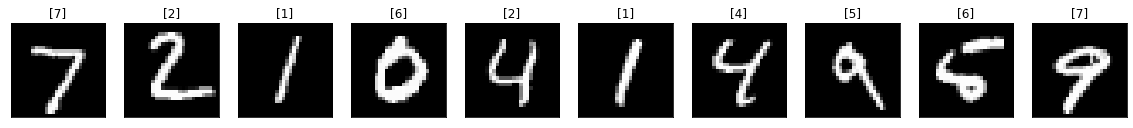

In [5]:
main(20, 0.01)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[6 6 6 6 5 6 3 2 6 7]]
Trenowanie sieci
epoch 1/20   error=0.127612
epoch 2/20   error=0.070735
epoch 3/20   error=0.058278
epoch 4/20   error=0.050513
epoch 5/20   error=0.044979
epoch 6/20   error=0.040680
epoch 7/20   error=0.037145
epoch 8/20   error=0.034098
epoch 9/20   error=0.031450
epoch 10/20   error=0.029200
epoch 11/20   error=0.027268
epoch 12/20   error=0.025591
epoch 13/20   error=0.024107
epoch 14/20   error=0.022767
epoch 15/20   error=0.021542
epoch 16/20   error=0.020415
epoch 17/20   error=0.019371
epoch 18/20   error=0.018412
epoch 19/20   error=0.017533
epoch 20/20   error=0.016719


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


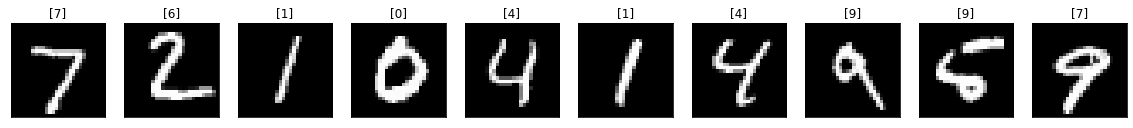

In [7]:
main(20, 0.1)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[3 3 0 9 9 3 9 3 3 9]]
Trenowanie sieci
epoch 1/20   error=0.142911
epoch 2/20   error=0.079063
epoch 3/20   error=0.062763
epoch 4/20   error=0.051076
epoch 5/20   error=0.043401
epoch 6/20   error=0.037434
epoch 7/20   error=0.032452
epoch 8/20   error=0.028728
epoch 9/20   error=0.025647
epoch 10/20   error=0.023239
epoch 11/20   error=0.020697
epoch 12/20   error=0.018929
epoch 13/20   error=0.017392
epoch 14/20   error=0.016170
epoch 15/20   error=0.015086
epoch 16/20   error=0.014250
epoch 17/20   error=0.013376
epoch 18/20   error=0.012622
epoch 19/20   error=0.011759
epoch 20/20   error=0.011157


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


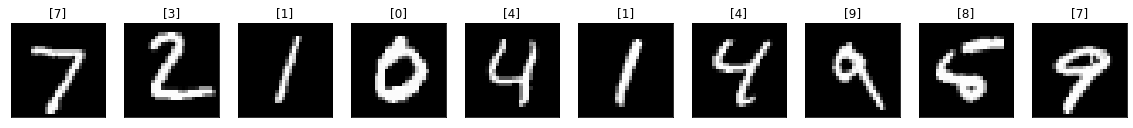

In [8]:
main(20, 0.25)

Dla sieci bez warstwy ukrytej najmniejszą wartość błędu uzyskano dla wartości learning_rate = 0.25

In [9]:
# jedna warstwa ukryta
def main_2(epochs, learning_rate):
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    # Convert y_train into one-hot format
    temp = []
    for i in range(len(Y_train)):
        temp.append(to_categorical(Y_train[i], num_classes=10))
    Y_train = np.array(temp)

    # Convert y_test into one-hot format
    temp = []
    for i in range(len(Y_test)):    
        temp.append(to_categorical(Y_test[i], num_classes=10))
    Y_test = np.array(temp)

    # Convert image into a vector
    image_vector_size = 28*28
    X_train = X_train.astype('float32')
    X_train = X_train / 255.0
    X_train = X_train.reshape(X_train.shape[0], 1, image_vector_size)
    X_test = X_test.astype('float32')
    X_test = X_test / 255.0
    X_test = X_test.reshape(X_test.shape[0], 1, image_vector_size)

    layers = []
    layers.append(FullyConnected(784, 28))
    layers.append(Tanh())
    layers.append(FullyConnected(28, 28))
    layers.append(Tanh())
    layers.append(FullyConnected(28, 10))
    layers.append(Tanh())
    net = Network(layers, learning_rate)

    print("Niewytrenowana sieć")
    print("Wartości prawdziwe:")
    print(Y_test[0:10])
    print("Odpowiedź sieci:")
    print((np.argmax(net(X_test[0:10]), axis=2)).T)
    print("Trenowanie sieci")
    net.fit(X_train[0:1000], Y_train[0:1000], epochs, learning_rate)
    print("Wytrenowana sieć")
    predictions = net(X_test[0:10])
    predictions = np.argmax(predictions, axis=2)
    print(predictions.T)

    

    fig, axes = plt.subplots(ncols=10, sharex=False,
                         sharey=True, figsize=(20, 4))
    for i in range(10):
        axes[i].set_title(predictions[i])
        axes[i].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    plt.show()


Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[1 6 6 3 0 3 0 5 3 3]]
Trenowanie sieci
epoch 1/20   error=0.286227
epoch 2/20   error=0.132781
epoch 3/20   error=0.100465
epoch 4/20   error=0.090045
epoch 5/20   error=0.084933
epoch 6/20   error=0.081596
epoch 7/20   error=0.079034
epoch 8/20   error=0.076874
epoch 9/20   error=0.074955
epoch 10/20   error=0.073204
epoch 11/20   error=0.071587
epoch 12/20   error=0.070087
epoch 13/20   error=0.068692
epoch 14/20   error=0.067389
epoch 15/20   error=0.066166
epoch 16/20   error=0.065013
epoch 17/20   error=0.063919
epoch 18/20   error=0.062877
epoch 19/20   error=0.061878
epoch 20/20   error=0.060918


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


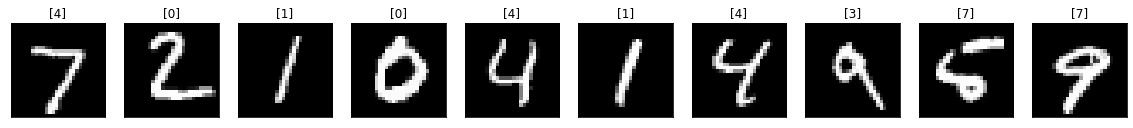

In [10]:
main_2(20, 0.01)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[9 6 9 8 1 9 9 6 4 0]]
Trenowanie sieci
epoch 1/20   error=0.132359
epoch 2/20   error=0.082259
epoch 3/20   error=0.071814
epoch 4/20   error=0.065042
epoch 5/20   error=0.058943
epoch 6/20   error=0.052837
epoch 7/20   error=0.047237
epoch 8/20   error=0.042526
epoch 9/20   error=0.038541
epoch 10/20   error=0.035157
epoch 11/20   error=0.032226
epoch 12/20   error=0.029619
epoch 13/20   error=0.027302
epoch 14/20   error=0.025275
epoch 15/20   error=0.023584
epoch 16/20   error=0.022115
epoch 17/20   error=0.020831
epoch 18/20   error=0.019714
epoch 19/20   error=0.018656
epoch 20/20   error=0.017727


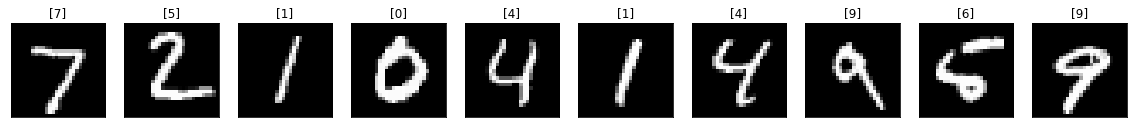

In [12]:
main_2(20, 0.1)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[7 1 8 2 2 8 4 5 2 2]]
Trenowanie sieci
epoch 1/20   error=0.149987
epoch 2/20   error=0.077106
epoch 3/20   error=0.055216
epoch 4/20   error=0.044309
epoch 5/20   error=0.036928
epoch 6/20   error=0.031866
epoch 7/20   error=0.027926
epoch 8/20   error=0.024820
epoch 9/20   error=0.022473
epoch 10/20   error=0.020465
epoch 11/20   error=0.018619
epoch 12/20   error=0.016980
epoch 13/20   error=0.015593
epoch 14/20   error=0.014417
epoch 15/20   error=0.013367
epoch 16/20   error=0.012436
epoch 17/20   error=0.011636
epoch 18/20   error=0.010899
epoch 19/20   error=0.010225
epoch 20/20   error=0.009611


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


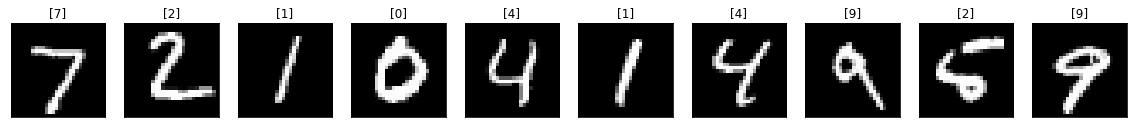

In [13]:
main_2(20, 0.25)

Dla sieci o jednej warstwie ukrytej najmniejszy błąd osiągamy dla wartości współczynnika learning_rate = 0.1

In [14]:
# dwie warstwy ukryte
def main_3(epochs, learning_rate):
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    # Convert y_train into one-hot format
    temp = []
    for i in range(len(Y_train)):
        temp.append(to_categorical(Y_train[i], num_classes=10))
    Y_train = np.array(temp)

    # Convert y_test into one-hot format
    temp = []
    for i in range(len(Y_test)):    
        temp.append(to_categorical(Y_test[i], num_classes=10))
    Y_test = np.array(temp)

    # Convert image into a vector
    image_vector_size = 28*28
    X_train = X_train.astype('float32')
    X_train = X_train / 255.0
    X_train = X_train.reshape(X_train.shape[0], 1, image_vector_size)
    X_test = X_test.astype('float32')
    X_test = X_test / 255.0
    X_test = X_test.reshape(X_test.shape[0], 1, image_vector_size)

    layers = []
    layers.append(FullyConnected(784, 28))
    layers.append(Tanh())
    layers.append(FullyConnected(28, 28))
    layers.append(Tanh())
    layers.append(FullyConnected(28, 28))
    layers.append(Tanh())
    layers.append(FullyConnected(28, 10))
    layers.append(Tanh())
    net = Network(layers, learning_rate)

    print("Niewytrenowana sieć")
    print("Wartości prawdziwe:")
    print(Y_test[0:10])
    print("Odpowiedź sieci:")
    print((np.argmax(net(X_test[0:10]), axis=2)).T)
    print("Trenowanie sieci")
    net.fit(X_train[0:1000], Y_train[0:1000], epochs, learning_rate)
    print("Wytrenowana sieć")
    predictions = net(X_test[0:10])
    predictions = np.argmax(predictions, axis=2)
    print(predictions.T)

    

    fig, axes = plt.subplots(ncols=10, sharex=False,
                         sharey=True, figsize=(20, 4))
    for i in range(10):
        axes[i].set_title(predictions[i])
        axes[i].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    plt.show()

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[8 1 1 2 2 1 1 5 1 2]]
Trenowanie sieci
epoch 1/20   error=0.194117
epoch 2/20   error=0.099028
epoch 3/20   error=0.086298
epoch 4/20   error=0.081452
epoch 5/20   error=0.078367
epoch 6/20   error=0.075945
epoch 7/20   error=0.073867
epoch 8/20   error=0.072003
epoch 9/20   error=0.070294
epoch 10/20   error=0.068709
epoch 11/20   error=0.067233
epoch 12/20   error=0.065853
epoch 13/20   error=0.064557
epoch 14/20   error=0.063339
epoch 15/20   error=0.062191
epoch 16/20   error=0.061106
epoch 17/20   error=0.060075
epoch 18/20   error=0.059090
epoch 19/20   error=0.058144
epoch 20/20   error=0.057232


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


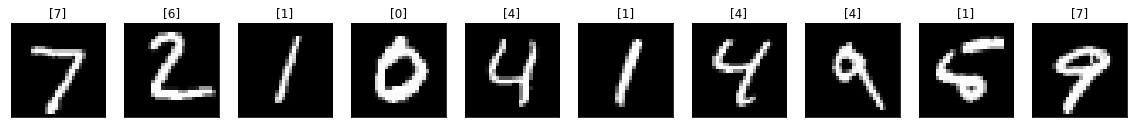

In [15]:
main_3(20, 0.01)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[3 0 0 1 3 1 1 2 3 3]]
Trenowanie sieci
epoch 1/20   error=0.128087
epoch 2/20   error=0.081754
epoch 3/20   error=0.068933
epoch 4/20   error=0.059805
epoch 5/20   error=0.052153
epoch 6/20   error=0.045507
epoch 7/20   error=0.040022
epoch 8/20   error=0.035549
epoch 9/20   error=0.031782
epoch 10/20   error=0.028608
epoch 11/20   error=0.025918
epoch 12/20   error=0.023592
epoch 13/20   error=0.021547
epoch 14/20   error=0.019749
epoch 15/20   error=0.018157
epoch 16/20   error=0.016714
epoch 17/20   error=0.015422
epoch 18/20   error=0.014281
epoch 19/20   error=0.013289
epoch 20/20   error=0.012426


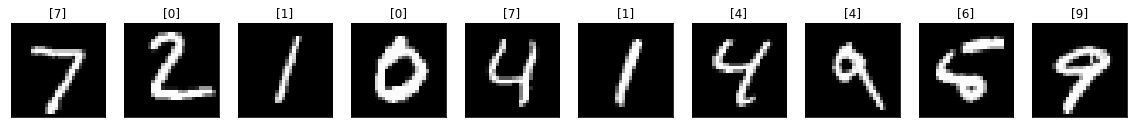

In [16]:
main_3(20, 0.1)

Niewytrenowana sieć
Wartości prawdziwe:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Odpowiedź sieci:
[[7 4 7 7 0 3 4 3 2 3]]
Trenowanie sieci
epoch 1/20   error=0.144842
epoch 2/20   error=0.083957
epoch 3/20   error=0.063050
epoch 4/20   error=0.048039
epoch 5/20   error=0.038171
epoch 6/20   error=0.031256
epoch 7/20   error=0.026445
epoch 8/20   error=0.021838
epoch 9/20   error=0.019031
epoch 10/20   error=0.016419
epoch 11/20   error=0.014747
epoch 12/20   error=0.013211
epoch 13/20   error=0.011699
epoch 14/20   error=0.010728
epoch 15/20   error=0.009883
epoch 16/20   error=0.009056
epoch 17/20   error=0.008439
epoch 18/20   error=0.007974
epoch 19/20   error=0.007484
epoch 20/20   error=0.007040


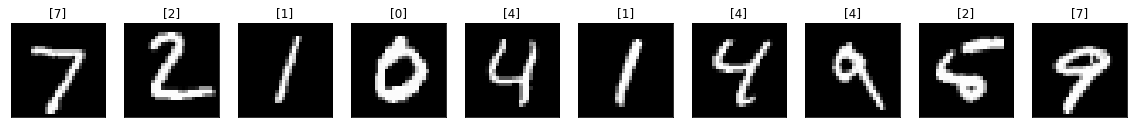

In [18]:
main_3(20, 0.25)

Dla sieci o dwóch warstwach ukrytych najlepszay wynik uzyskano dla współczynnika learning_rate = 0.25

# Wnioski

Sieci neuronowe są dobrym klasyfikatorem. Stworzony przeze mnie model działa dobrze (niskie wartości błędów), ale nie rozpoznaje jednocześnie wszystkich dziesięciu cyfr z obrazków.